<a href="https://colab.research.google.com/github/ahmadSoliman94/Machine-Learning/blob/main/vgg_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget   brain-tumor-mri-dataset.zip  https://www.dropbox.com/s/n2bj9xj1cpyrboi/brain-tumor-mri-dataset.zip

--2022-04-28 20:17:06--  http://brain-tumor-mri-dataset.zip/
Resolving brain-tumor-mri-dataset.zip (brain-tumor-mri-dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘brain-tumor-mri-dataset.zip’
--2022-04-28 20:17:06--  https://www.dropbox.com/s/n2bj9xj1cpyrboi/brain-tumor-mri-dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/n2bj9xj1cpyrboi/brain-tumor-mri-dataset.zip [following]
--2022-04-28 20:17:06--  https://www.dropbox.com/s/raw/n2bj9xj1cpyrboi/brain-tumor-mri-dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2ef4a843c9d23f580c4c24d44a.dl.dropboxusercontent.com/cd/0/inline/BkSMNYbvHlHFt3xRm4ULnRg0qQpH7_5lm79xZ674Fk_jzPvDU-IhXtCb6KrSzlaHuM3VAOMaNLt29c3

In [ ]:
import os
from zipfile import ZipFile
work_dir = os.getcwd()                                                
with ZipFile(os.path.join(work_dir ,'/content/brain-tumor-mri-dataset.zip'),'r') as zipobject:
  zipobject.extractall()

In [ ]:
train_data_dir =  "/content/Training"
validation_data_dir ="/content/Testing"

In [ ]:

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

# Define a data generator with data augmentation transformations for the 
# training dataset.
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


train_set = train_datagen.flow_from_directory(train_data_dir,
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(validation_data_dir,
                                              target_size=(224, 224),
                                              batch_size=64,
                                              class_mode='categorical')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications.vgg16  import preprocess_input

In [ ]:
base_model = keras.applications.VGG16(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)  

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in base_model.layers[:-12]:
    layer.trainable=False

In [ ]:
# Freeze the base_model
#base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(224, 224, 3))

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.Dense(512,activation='relu')(x)
out = keras.layers.Dense(4,activation='softmax')(x)
model =keras.Model(inputs=base_model.input, outputs=out)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()]
)


In [ ]:

epochs = 13

# train_num = train_set.samples  # num of training samples
# valid_num = valid_set.samples  # num of validation samples

vgg16_history = model.fit(train_set,
                                steps_per_epoch =85,
                                validation_data=valid_set,
                                validation_steps=12,
                                epochs=epochs,
)

Epoch 1/13


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


85/85 [==============================] - 136s 2s/step - loss: 0.6393 - categorical_accuracy: 0.7457 - val_loss: 0.3693 - val_categorical_accuracy: 0.8529
Epoch 2/13
85/85 [==============================] - 114s 1s/step - loss: 0.2716 - categorical_accuracy: 0.9023 - val_loss: 0.8088 - val_categorical_accuracy: 0.7982
Epoch 3/13
85/85 [==============================] - 115s 1s/step - loss: 0.2601 - categorical_accuracy: 0.9000 - val_loss: 0.1833 - val_categorical_accuracy: 0.9206
Epoch 4/13
85/85 [==============================] - 115s 1s/step - loss: 0.1338 - categorical_accuracy: 0.9496 - val_loss: 0.1222 - val_categorical_accuracy: 0.9531
Epoch 5/13
85/85 [==============================] - 114s 1s/step - loss: 0.0953 - categorical_accuracy: 0.9653 - val_loss: 0.1772 - val_categorical_accuracy: 0.9362
Epoch 6/13
85/85 [==============================] - 114s 1s/step - loss: 0.0801 - categorical_accuracy: 0.9703 - val_loss: 0.0967 - val_categorical_accuracy: 0.9688
Epoch 7/13
85/85 [===

In [ ]:
results = model.evaluate(valid_set)

print('val loss:', results[0])
print('val acc:', results[1])


21/21 [==============================] - 16s 748ms/step - loss: 0.0683 - categorical_accuracy: 0.9786
val loss: 0.06828851997852325
val acc: 0.9786422848701477


In [ ]:
import  numpy  as np
pred = model.predict(valid_set)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in valid_set.classes]

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
acc = accuracy_score(y_test, pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      glioma       0.24      0.23      0.24       300
  meningioma       0.21      0.21      0.21       306
     notumor       0.33      0.33      0.33       405
   pituitary       0.21      0.22      0.22       300

    accuracy                           0.25      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.25      0.25      0.25      1311



In [ ]:
import matplotlib.pyplot as plt

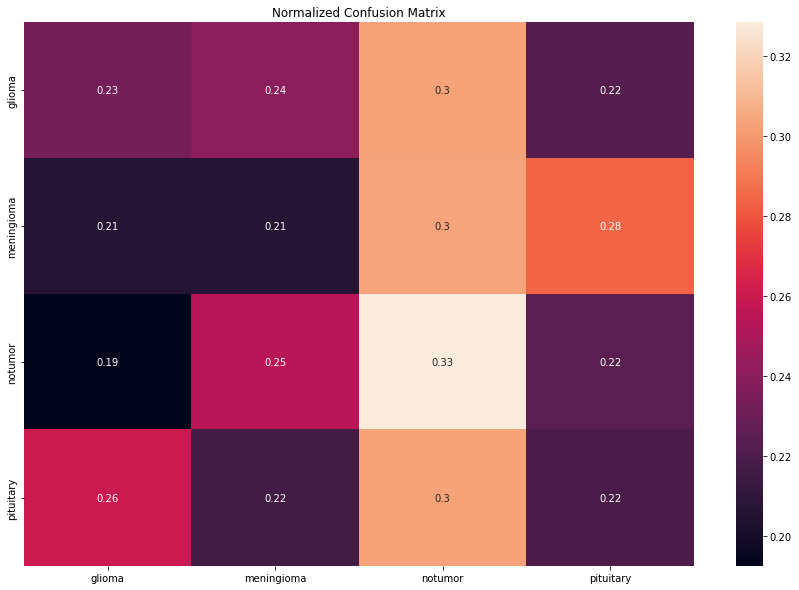

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters for plotting
plt.rc('figure', figsize=(8, 4))
sns.set(font_scale=1)

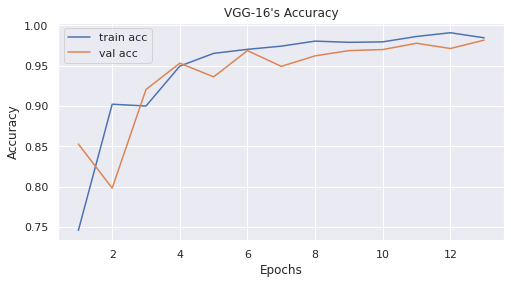

In [ ]:
train_acc = vgg16_history.history['categorical_accuracy']
val_acc = vgg16_history.history['val_categorical_accuracy']

epochs_list = list(range(1, epochs + 1))

plt.plot(epochs_list, train_acc, label='train acc')
plt.plot(epochs_list, val_acc, label='val acc')
plt.title("VGG-16's Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

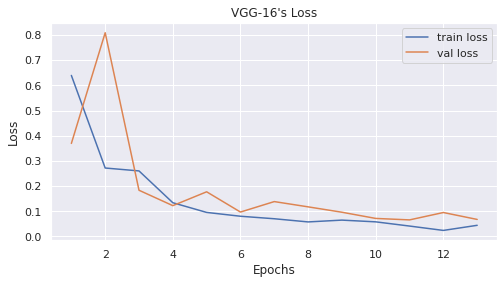

In [ ]:
train_loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

plt.plot(epochs_list, train_loss, label='train loss')
plt.plot(epochs_list, val_loss, label='val loss')
plt.title("VGG-16's Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')